In [1]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
import requests
import json

In [2]:
#downloading network from OSMnx API
G = ox.graph_from_place('Amsterdam, Netherlands',network_type='walk')

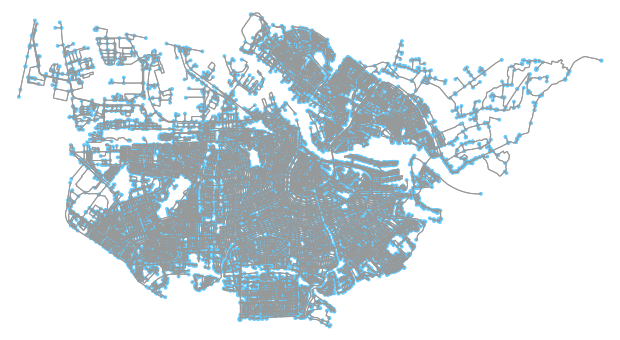

(<Figure size 1314.6x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x136ce8080>)

In [3]:
ox.plot_graph(G)

In [5]:
#Connecting to Amsterdam API to get the coordinates of our chosen addresses
def send_request_loc(adres):
# GET https://api.data.amsterdam.nl/bag/openbareruimte/
    response = requests.get(
        url="https://api.data.amsterdam.nl/atlas/search/adres/",
        params={"q": adres,},)
    resp_str = response.content
    resp_dict = json.loads(resp_str)
    if len(resp_dict['results']) == 0:
        coord = ['Geen gegevens']
    else:
        coord = resp_dict['results'][0]['centroid']
    
    return coord

In [6]:
#loading land use dataset
df = pd.read_csv('data/GRONDGEBRUIK_2017.csv',sep=';')

In [9]:
#Setting geometries to MultiPolygon and adding geometry column to pandas dataframe
geometry = []

for i in range(0,len(df)):

    p = wkt.loads(df.iloc[i]['WKT_LNG_LAT'])
    geo = MultiPolygon([p])
    geometry.append(geo)
    
df['geometry'] = geometry

In [11]:
#creating GeoDataFrame
gdf = gpd.GeoDataFrame(df,geometry='geometry')

In [12]:
#Retrieving coordinates from Amsterdam API
loc1 = send_request_loc('Stationsplein')
loc2 = send_request_loc('Linnaeuskade 31')

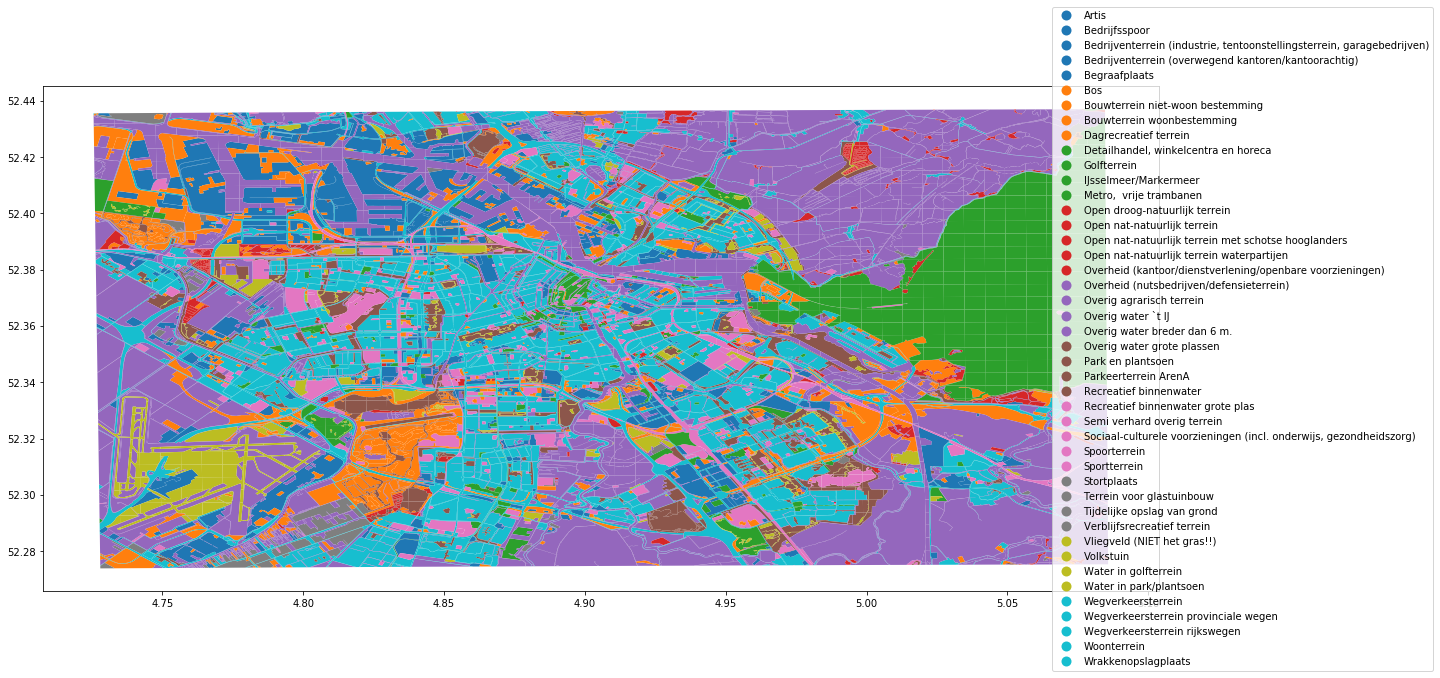

In [13]:
#Plotting the land use map
gdf.plot(column='AMScode_Oms',figsize= (20,30),legend=True,legend_kwds={'loc': 'center right','bbox_to_anchor':(1.25, 0, 0, 1)})

In [14]:
#Finding nodes nearest to the source and target of the route
werk1 = ox.get_nearest_node(G,(loc1[1],loc1[0]))
werk2 = ox.get_nearest_node(G,(loc2[1],loc2[0]))


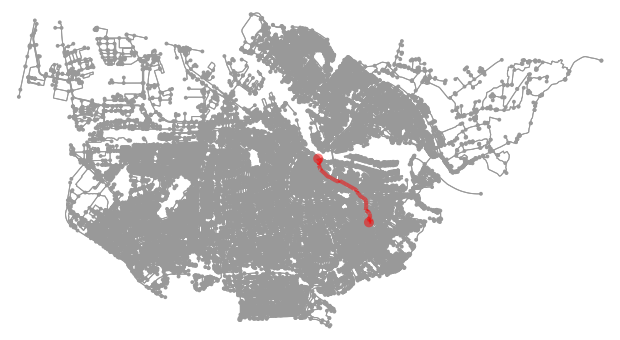

(<Figure size 1314.6x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x158299eb8>)

In [15]:
#Calculating shortest path, plotting map to check
route = nx.shortest_path(G, werk1, werk2,weight='length')
ox.plot_graph_route(G, route)

In [37]:
#Saving the route as LineString
line = []
for i in route:
    point = (G.node[i]['x'],G.node[i]['y'])
    line.append(point)

line = LineString(line)

In [44]:
#Creating geodataframe
route_df = gpd.GeoDataFrame(data= [['route 1',line]],columns=['naam_route','geometry'],geometry='geometry')

In [45]:
#matching crs of geodataframes
route_df.crs = gdf.crs

In [46]:
#Adding  a buffer around the line in order the intersect with more of the surrounding
route_df.geometry = route_df.geometry.buffer(0.0002)

In [49]:
#Finding the intersecting areas in both geodataframes
joined_gdf = gpd.sjoin(gdf, route_df, op='intersects')

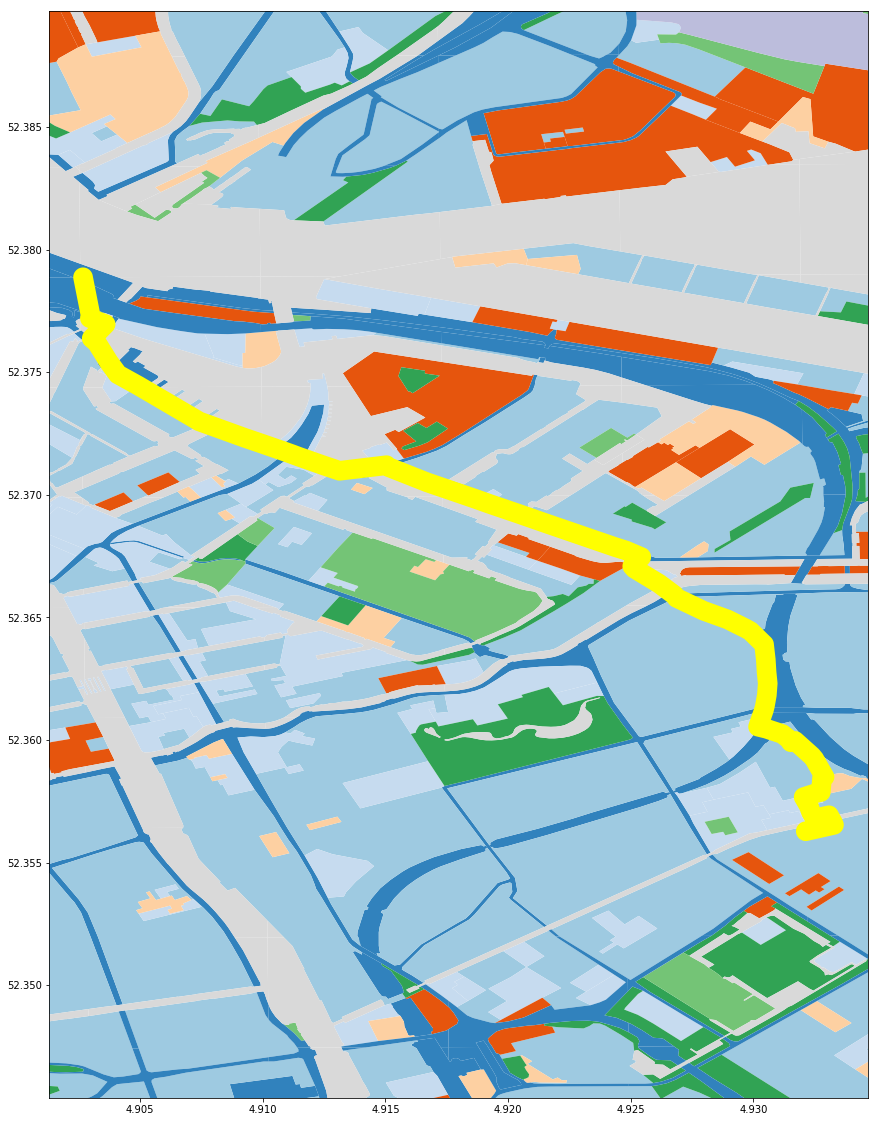

In [50]:
#Plotting the route on the land use map. 
ax = gdf.plot(column= "AMScode",figsize=(20,20),cmap='tab20c')
route_df.plot(ax=ax, color='yellow')
minx, miny, maxx, maxy = route_df.total_bounds 
ax.set_xlim(minx * 0.9998 , maxx * 1.0002)
ax.set_ylim(miny * 0.9998, maxy * 1.0002)
plt.show()

In [26]:
#Calculating the area of each intersection between the line and the land use polygons
area = []
for i in joined_gdf.geometry:
    ar = i.intersection(route_df.iloc[0].geometry).area
    area.append(ar)
    
joined_gdf['area'] = area

In [29]:
#Summing these intersections to get the total for each land use 
intersection = pd.DataFrame(joined_gdf.groupby(['AMScode_Oms'])['area'].sum())

In [30]:
#Dropping 'Wegverkeersterrein' (roads). Since this is not part of the surroundings but the actual surface we are using
intersection.drop('Wegverkeersterrein',axis=0, inplace=True)

In [31]:
#Calculating the sum of all areas in order to calculate percentage
area_sum = intersection.area.sum(axis=0)
intersection['percentage_land_use'] = intersection['area'] / area_sum * 100

In [34]:
#Dropping the index name and plotting the tabel
intersection.index.name = None
pd.DataFrame(intersection['percentage_land_use'])

,percentage_land_use
"Bedrijventerrein (industrie, tentoonstellingsterrein, garagebedrijven)",0.051631
Bouwterrein woonbestemming,1.122601
"Detailhandel, winkelcentra en horeca",1.694507
"Metro, vrije trambanen",0.099403
Overig water breder dan 6 m.,16.141307
"Sociaal-culturele voorzieningen (incl. onderwijs, gezondheidszorg)",11.292129
Spoorterrein,8.728704
Woonterrein,60.869717
